<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/BERT_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT Fine-Tuning Tutorial 
#by Rick Rejeleene


##1) Why we needed BERT? 

One of the Biggest Challenge was lack of Training Data in NLP for NLP tasks. 

NLP tasks could be sentence classification, summarization, question answering, sentiment analysis etc.

Now, As Human we can label dataset but it will take too much time for larger dataset, say 1 million rows

Therefore, researchers introduce large unanotated text from Web (Pretraining)

And then this pre-trained dataset can be fine-tuned on smaller task specific dataset

#2) What is language modeling? What problem does BERT solve? 

Basically, we want to fill in the blanks in a sentence based on context 

Eg: The Man went to store to buy a ___ of shoes

A Language model will fill 80% with pair, and 20% cart

Before, BERT was introduce, a language model will look into left to right or right to left

A One Directional approach, it works well for generating sentences

BERT is bi-directional (technological innovation) trained, thus we can understand language context


#3) Okay, How does it work? 

Simple, Masked Language Model. 

Basically, We randomly mask a word in a sentence and predict them. 

BERT is bidirectional - what does that mean? 

Pre-trained language model can be context free or context based. Basically, context means, understanding a sentence contextually. 

Take word, "bank" in bank of river vs a bank account.

Word2Vec, a context free model would represent this context free. 

Now, context based model will represent this word based on the other words. In other words, BERT represents based on previous and next context. 


#4) How does it Work? Rick, give me the engineering details! 

BERT is based on transfomer architecture. 

Transformer's attention mechanism learns relationship between words in context (What an impressive innovation!)

Transfomer gets input in encoder (language model) and then uses decoder to produce prediction for task. 

Encoder part is enough as we only need to generate a language model. 

a) INPUT for BERT is a sequence of tokens 

b) This is converted to vectors and processed in neural network 

c) Before the above two steps, BERT needs to be decorated with meta data

#Steps: 

1) Token Embedding: 

Add [CLS] at beginning, Add [SEP] at end

Help BERT with vector representation of words 

2) Segment Embedding: 

Marker A or B added to sentence.

This helps to distinguish between two sentences

Label to distinguish sentences 
0: "I like cats"
1: "I like dogs"
(Vector Representation)


3) Position Embedding:

Position Embedding to help BERT indictate position of token 


4) Masked Language Model: 

Mask 15% randomly of sentence in input replacing with 
[MASK] token 

Run entire sequence through BERT attention based encoder 

and predict only masked words based on context


5) Next Sentence Prediction: 

We need to understand relationship between two sentences 

We saw before, there's [SEP] between two sentences. 

During training, model learns to predict second sentence if it's in original text. 

BERT is required to predict if second sentence is random or not.

Input = [CLS] Man went to store [SEP] he bought gallon of milk 

Label = isNext

Input = [CLS] the man [Mask] to the store [SEP] penguin [MASK] are flight 

Label = NotNext

#Architecture

Pre-trained versions of BERT 

BERT-Base: 12-layer, 768-hidden-nodes, 12-attention-heads, 110M parameters

BERT-Large: 24-layer, 1024-hidden-nodes, 16-attention-heads, 340M parameters

BERT-Base was trained on 4 cloud TPUs for 4 days

BERT-Large was trained on 16 TPUs for 4 days











































In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#We now engineer BERT to apply on Sentence Classification Task

#1) Check if GPU is Detected

In [ ]:
#We are Checking for GPU
#GPU is Graphical Processing Unit
import tensorflow as tf

#Get the GPU device name

device_name = tf.test.gpu_device_name()

#Device name
if device_name == '/device:GPU:0':
  print('Found GPU at:{}'.format(device_name))
else:
  raise SystemError('GPU device not found')
  

Found GPU at:/device:GPU:0


# 2) Review: BERT is based on Encoder part of Transformer

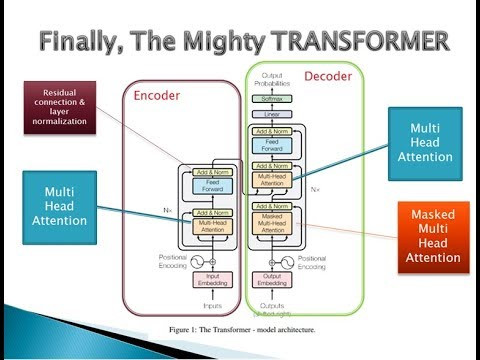

In [ ]:
from IPython.display import Image
Image(filename='/content/sample_data/transformer.jpg')

#This is Transformer Architecture, but we need only need for BERT one part

# 3) Review BERT Architecture

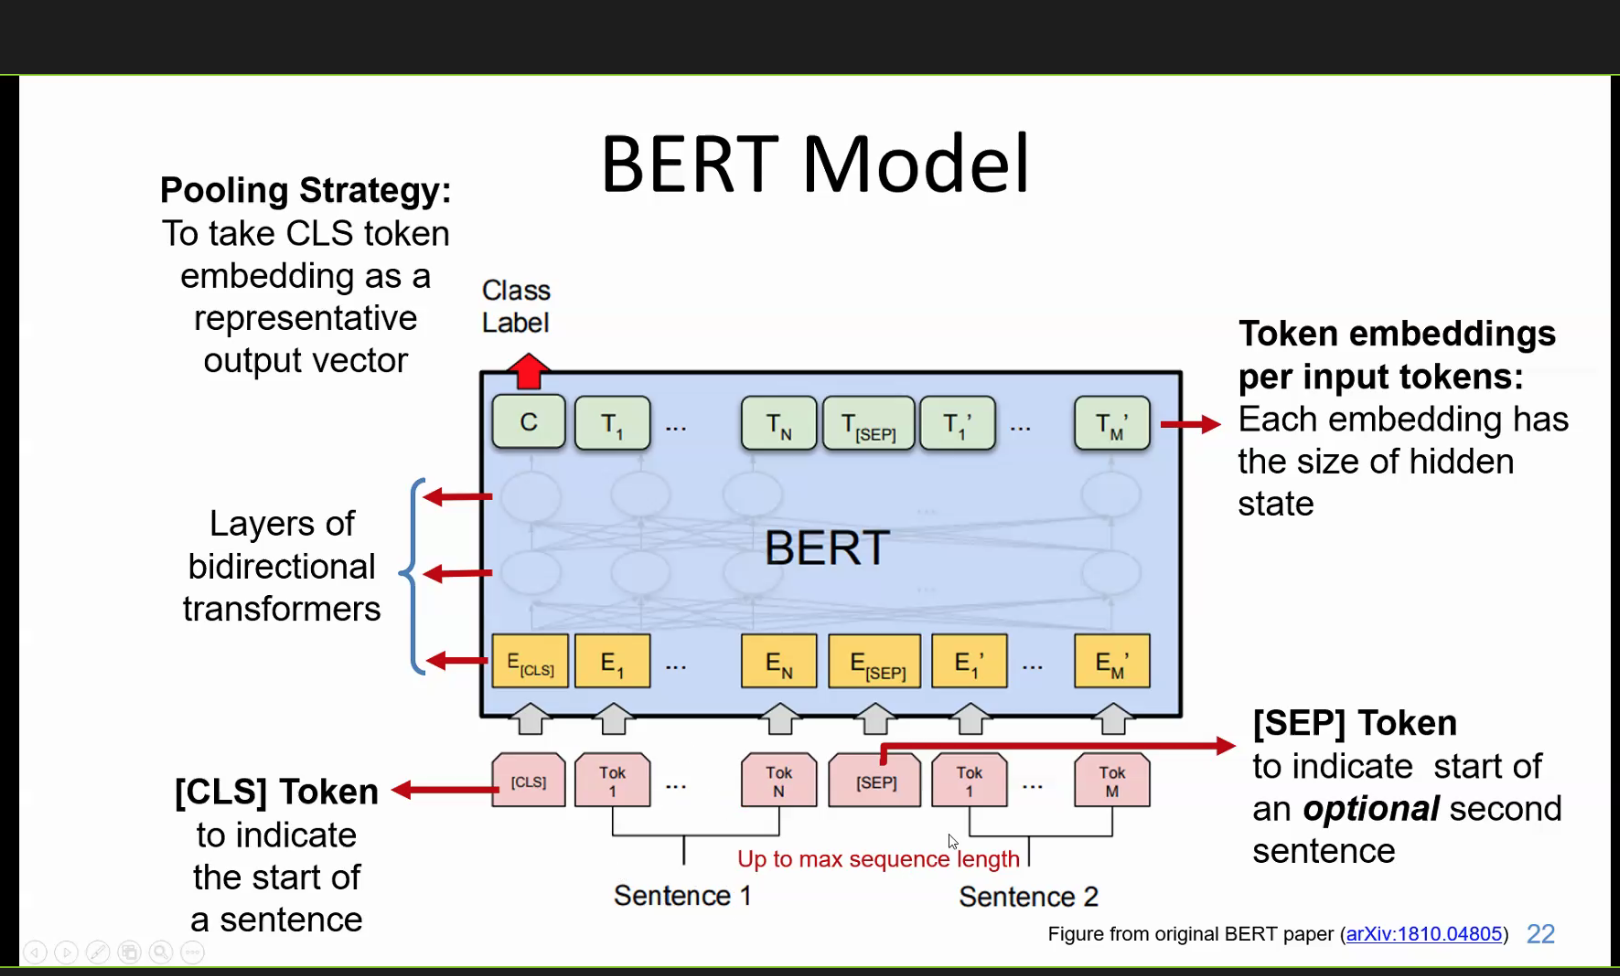

In [ ]:
Image(filename='/content/sample_data/Bert.png', width="630")
#1)Tokenizer
#2)Bidirectional Transformer
#3)Pooling Strategy 

4) Check CUDA is available (Parrell computing)

In [ ]:
import torch

if torch.cuda.is_available():

  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

#If not....
else: 
  print('No GPU available, using CPU instead.')
  device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#Install Hugging Face Transformer Library
!pip install transformers

     |████████████████████████████████| 1.3MB 4.7MB/s 
     |████████████████████████████████| 1.1MB 30.9MB/s 
     |████████████████████████████████| 890kB 39.8MB/s 
     |████████████████████████████████| 2.9MB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e66fdcdc42d0d9922cd02a35f5ec05f9fe3f74888bedd1da894096abd2e047bd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Install Python download utility 
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=ddfbf28e3151d6e04729c35b246ebf6ffc5a7ea7441d1695222401128af934c4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


5) Download COLA dataset from public 

In [ ]:
#Download a dataset 

import wget #pure python download utility
import os   #OS module

print('We are downloading dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

#Downloads dataset in our Colab Repo

We are downloading dataset...


In [ ]:
#unzip the file so that it exists in our file system

if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip


Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


6) Load Dataset from Sample folder

In [ ]:
import pandas as pd

#Load the dataset 

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv",delimiter='\t', header=None, names=['sentence_source','label','label_notes','sentence'])

#Report 

print('Number of training sentences:{:,}\n'.format(df.shape[0]))

df.sample(10)


#We have Label, Label_Notes, Sentence, Sentence_Source


Number of training sentences:8,551



,sentence_source,label,label_notes,sentence
2499,l-93,1,NaN,The silversmith pounded the metal flat.
3812,ks08,1,NaN,The little cat devoured a mouse last night.
2789,l-93,0,*,Steve pelted acorns against Anna.
6065,c_13,1,NaN,Rory has eaten the muffins.
6549,g_81,0,*,The talkative and a bully man entered.
2446,l-93,1,NaN,There developed a problem.
8544,ad03,1,NaN,Gilgamesh hasn't kissed Ishtar.
4105,ks08,0,*,The authorities charged the students of the ch...
4794,ks08,1,NaN,John inquired which book he should read.
2860,l-93,0,*,Carol carved at the stone.


In [ ]:
#We are selecting in Label Column, Whichever label is 0, and 5 sample. 
#We select only sentence and label column 
df.loc[df.label==0].sample(5)[['sentence','label']]

,sentence,label
284,"He seems to become more corrupt, if every sena...",0
7792,He kicked herself,0
1440,Did that he played the piano surprise you?,0
294,"Which problem the sooner you solve, will the m...",0
2660,Pat cured of pneumonia.,0


In [ ]:
#Select Sentences and Labels
sentences = df.sentence.values
labels = df.label.values

# 7) Import Tokenizer from Hugging Face 

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Import Tokenizer from Hugging Face 
#We use pre-trained BERT model files

from transformers import BertTokenizer

#Load Bert Tokenizer

print('Loading BERT tokenizer....')
#Uncase means, it has only lower case letters
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Loading BERT tokenizer....


In [ ]:
print(sentences)

["Our friends won't buy this analysis, let alone the next one we propose."
 "One more pseudo generalization and I'm giving up."
 "One more pseudo generalization or I'm giving up." ...
 'It is easy to slay the Gorgon.'
 'I had the strangest feeling that I knew you.'
 'What all did you get for Christmas?']


In [ ]:
#Tokenize Sentences
print('Original', sentences[0])

print('Tokenized:', tokenizer.tokenize(sentences[0]))

print('Token IDs:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))



Original Our friends won't buy this analysis, let alone the next one we propose.
Tokenized: ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs: [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


#8) Tokenize:
          - Add Special Token
          -Truncate All Sentences containing single constant length
          -Differentiate sentences using Attention Mechanism

In [ ]:
max_len = 0
for sent in sentences: 
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print('Max sentence length:', max_len)


Max sentence length: 47


In [ ]:
#Tokenize all sentences
#We use tokenize.encode_plus which 
#Splits the sentences into tokens
#Map the Tokens to their IDS
#Truncate Sentences to same length
#Create Attention Mask which differentiates from real tokens [PAD]

input_ids = [] 
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(sent, #Sentence to encode from the loop 
                  add_special_tokens=True, #Add [SEP] and [CLS]
                  max_length=64, 
                  pad_to_max_length=True, #Padd and Truncate all Sentences
                  return_attention_mask=True, #Construct Attention Mask
                  return_tensors = 'pt', # Return as Pytorch Tensors
                  truncation=True)
  
  input_ids.append(encoded_dict['input_ids']) #Append the encoded form to list 
  attention_masks.append(encoded_dict['attention_mask']) #Add Attention Mask

#Convert the list into tensors 

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
#Output in encoded_dic
encoded_dict

{'input_ids': tensor([[ 101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

#9) Training and Validation Dataset

In [ ]:
#Next, We train the Dataset 

#Divide the training set for 90% training and 10% validation

from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

print(dataset)

In [ ]:
#Next We want to Train the Dataset 

#Divide the Training Set for 90% training and %10 validation

from torch.utils.data import TensorDataset, random_split
#Combine training input into TensorDataset 

dataset = TensorDataset(input_ids, attention_masks, labels)

#Calculate number of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size 

#Divide dataset by randomly selecting samples. 

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))





7,695 training samples
  856 validation samples


#9.1 Load into Data Loader 
  to save into memory

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#We give batch size as 16 or 32
batch_size = 32 


train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

#Order doesn't matter in validation
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)





In [ ]:
#BERT for Sequence Classification
#Hugging Face has interfaces for common NLP task

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=2, output_attentions=False, 
                                                      output_hidden_states=False,)

#Ask PyTorch to run on CUDA
model.cuda()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#In the Output Above, We have 
#Embedding Layer
#First of Twelve Transformers 
#Output Layer



In [ ]:
params = list(model.named_parameters())

print('BERT model has {:} different named parameters.\n'.format(len(params)))
print('===Embedding layer===\n')

for p in params[0:5]:
  print("{:<55}{:>12}".format(p[0],str(tuple(p[1].size()))))

print('\n====First Transformer====\n')

for p in params[5:21]:
  print("{:<55}{:>12}".format(p[0],str(tuple(p[1].size()))))
print('\n===Output Layer====\n')
for p in params[-4:]:
  print("{:<55}{:>22}".format(p[0],str(tuple(p[1].size()))))


BERT model has 201 different named parameters.

===Embedding layer===

bert.embeddings.word_embeddings.weight                 (30522, 768)
bert.embeddings.position_embeddings.weight               (512, 768)
bert.embeddings.token_type_embeddings.weight               (2, 768)
bert.embeddings.LayerNorm.weight                             (768,)
bert.embeddings.LayerNorm.bias                               (768,)

====First Transformer====

bert.encoder.layer.0.attention.self.query.weight         (768, 768)
bert.encoder.layer.0.attention.self.query.bias               (768,)
bert.encoder.layer.0.attention.self.key.weight           (768, 768)
bert.encoder.layer.0.attention.self.key.bias                 (768,)
bert.encoder.layer.0.attention.self.value.weight         (768, 768)
bert.encoder.layer.0.attention.self.value.bias               (768,)
bert.encoder.layer.0.attention.output.dense.weight       (768, 768)
bert.encoder.layer.0.attention.output.dense.bias             (768,)
bert.encoder.laye

In [ ]:

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

#10) Optimizer & Learning Rate

We have our model loaded, we need to use hyperparameters


In [ ]:
#AdamW is a library from Hugging Face
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
scheduler

#11) Training Loop 
 
 What we do here -- we have training phase and validation phase in a loop 



In [ ]:
#Training: 
#1 We unpack our data inputs and labels 
#2 Load data into GPU for acceleration 
#3 Clear out Gradients from previous phase 
#4 Forward Pass 
#5 Backward Pass (backprop)
#6 Update using Optimizer.step()
#7 Monitor Progress for Variables 

#Evaluation: 
#1 We unpack our data inputs and labels 
#2 Load into GPU
#3 Forward Pass 
#4 Compute Loss and Monitor Progress for Variables 


#Defining Helper Function
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Format Time for Helper Function 

import time
import datetime 

def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))


# 12) Training


In [ ]:
#Import Module 

import random 
import numpy as np 
import torch
import time

#Set seed value all over the place
#Seed value is used for saving random function
#42 times, the random number 

seed_val = 42 

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Training and Validation 
training_stats = [] 

#Measure training time for whole run. 
total_t0 = time.time() 

#For each epoch....
for epoch_i in range(0, epochs):

  print("")
  print("===== Epoch {:} /{:} =======".format(epoch_i + 1, epochs))
  print('Training....')

  #Measure how long the training epoch takes 
  t0 = time.time() 

  #Reset the total loss for this epoch. 
  total_train_loss = 0 

  #Change Model into Training Mode
  model.train() 

  #For each batch of training data
  for step, batch in enumerate(train_dataloader):
    #Update 40 batches: 
      elapsed = format_time(time.time()-t0)
      elapsed = format_time(time.time()-t0)
      #Report
      print('Batch{:>5,} of {:>5,}.Elapsed:{:}.'.format(step,len(train_dataloader),elapsed))
      
      #Unpack to dataloader and copy to pytorch tensors
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      model.zero_grad()
      loss, logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
      
      total_train_loss += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()

      avg_train_loss = total_train_loss /len(train_dataloader)
      training_time = format_time(time.time() - t0)

      print("")
      print("Average training loss: {0:.2f}".format(avg_train_loss))
      print("Training epoch took:{:}".format(training_time))

      ##Validation
      print("")
      print("Running Validation")
      t0 = time.time() 

      model.eval()
      total_eval_accuracy = 0
      total_eval_loss = 0 
      nb_eval_steps = 0

      for batch in validation_dataloader: 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

          #Calculate Logit Predictions
          (loss, logits) = model(b_input_ids, token_type_ids = None, 
          attention_mask=b_input_mask, labels=b_labels)
          #Accumulate validation loss
          total_eval_loss += loss.item()

          #Move Logits and Labels 
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          #total accuracy 
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          
          avg_val_accuracy = total_eval_accuracy/len(validation_dataloader)


          #Calculate average loss over all batches
          avg_val_loss = total_eval_loss/len(validation_dataloader)
          print("Accuracy {0:.2f}".format(avg_val_accuracy))

          #Measure how long validation run took. 
          validation_time = format_time(time.time() - t0)

          print("Validation Loss: {0:.2f}".format(avg_val_loss))
          print("Validation took: {:}".format(validation_time))
          
          #Record all statistics 
          training_stats.append(
              {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
          )

print("")
print("Training complete!")
print("Total training took{:}(h:mm:ss)".format(format_time(time.time()-total_t0)))















In [ ]:
#Training the dataset 

import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:30.
  Batch   120  of    241.    Elapsed: 0:00:44.
  Batch   160  of    241.    Elapsed: 0:00:59.
  Batch   200  of    241.    Elapsed: 0:01:14.
  Batch   240  of    241.    Elapsed: 0:01:28.

  Average training loss: 0.44
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.41
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:29.
  Batch   120  of    241.    Elapsed: 0:00:44.
  Batch   160  of    241.    Elapsed: 0:00:59.
  Batch   200  of    241.    Elapsed: 0:01:13.
  Batch   240  of    241.    Elapsed: 0:01:28.

  Average training loss: 0.28
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.48
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
#Summary of Progress


import pandas as pd 

#Display flots with two decimal places

pd.set_option('precision', 2)

#Create a DataFrame from out training statistics 

df_stats = pd.DataFrame(data=training_stats)

#Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')
#Display table
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.44,0.41,0.83,0:01:28,0:00:03
2,0.28,0.48,0.83,0:01:28,0:00:03
3,0.18,0.55,0.83,0:01:28,0:00:03
4,0.13,0.60,0.83,0:01:28,0:00:03


Training Loss is Going Down with Each Epoch 

Our Model is too long, over-fitting training data 

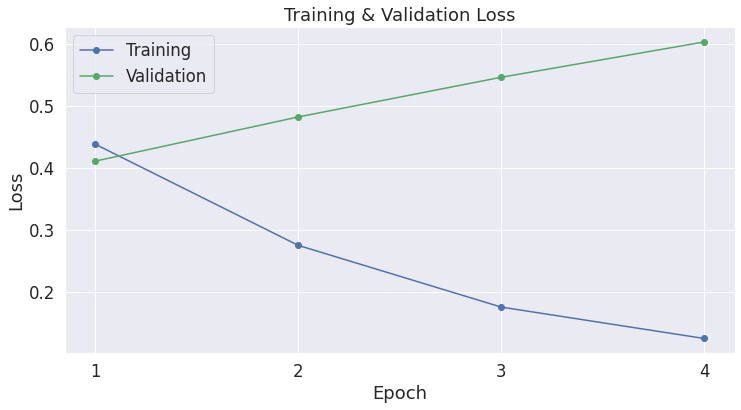

In [ ]:
#Import Library 

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#10) Performance 
-Load Holdout dataset 
-Prepare input 
-Evaluate using Matthew's Correlation
-

In [ ]:
import pandas as pd

# Read Dataset as Pandas Dataframe
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create Sentence 
sentences = df.sentence.values

#Create Label 
labels = df.label.values

#Tokenize sentence, map token to word ID

input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True, 
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
#Matthew Correlation Coefficient 
#Measure of Quality of Binary and Multiclass classifciaton 
#It's between -1 to +1 


from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate Matthew Correlation 
print('Calculating Matthews Correlation for each batch...')

# For Each Batch
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Correlation for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


We Create a Barplot to show MCC for tests

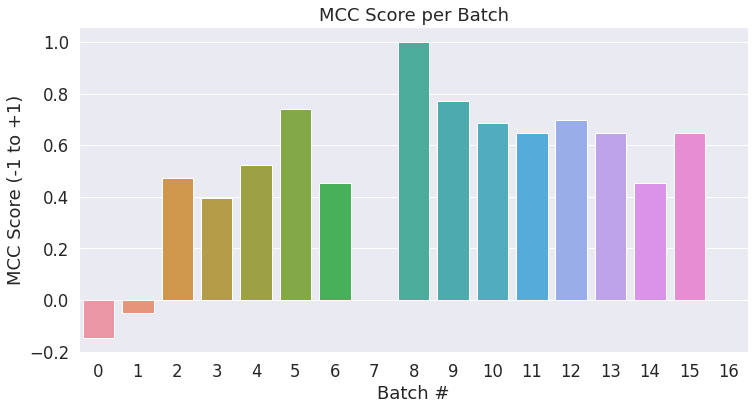

In [ ]:

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

We Combine Result for all Batches and Calculate Final MCC Score

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.545


#11) Official Glue Score 

(https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy) 

1) MacALBERT + DKM
GitHub/Model URL:  N/A
Submitted: 27 Aug
Score:
 90.7



#Conclusion: 

We can create pre-trained BERT Model 
and then apply to specific NLP task

#Miscellaneous for further understanding 

1.   List item

1.   List item
2.   List item


2.   List item



1) Why do we need BERT at all? 

Firstly, We need a language model, Why? Because we want to estimate probability distribution of various lingusitic units eg: words, sentences. Why? Because, without a way to model the language, we would not be able to do many of Natural Language Translation task. Okay, What kind of Tasks? 
Well, We can do language summarization, abstraction, Text Generation, Topic Modeling, Sentence Generation, Sentiment Analysis. 


Okay great -- So, Why BERT? 

Before, We go into BERT. We want to understand Embedding. An Embedding is a type of representation for word or paragraph. There's static and contexuualized word embedding. Static embeddings cannot address problem of polysemy (multiple meaning for one word). 

BERT is based on Transformer Decoder architecture



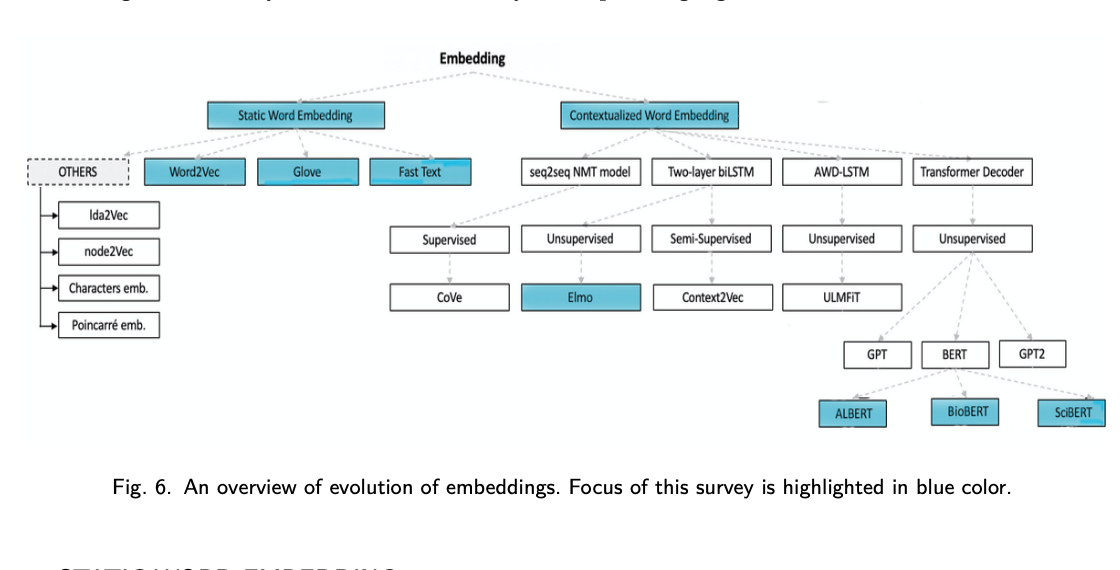


2) Why does BERT takes too much resources? 

3) Why BERT has 768 rdimensions? 

4) What is maximum length of SBERT?

5) What does Pooling Do? 


6) Why does Attention Mechanism takes too much resources? 

Firstly, Attention is a 


How does Binary Classification Work in Loss Function Training?


Why BERT takes too much resources? 

What is attention layer? 

What is maximum length of SBERT? Why?

What is u and v in SBERT? 

What is the size of u and v? 

What is Loss Function?

Imagine we are in top of hill and we want to climb down. How can we decide where to walk towards? 

We look around to see all possible paths.

We reject the ones going up. Because it will cost more energy and make task difficult. 

We choose to take the path that we think has the most slope downhill.

In simple words, loss function maps decisions to their associated costs.

During training, we want to minimize error for each learning process. 

Attention mechanism, What is it? Why does it take so much time?

Binary Classification with an example? 

What does Pooling do? 
Pooling is similar to Convolution.

Convlution maps a reigion of an image to a feature map. In an Image, pixels are mapped to edge feature. 
This repeated again and again. 

Next within this, we want to detect higher level features from low level blocks as detecting corner. 

The invariance at feature level is achieved by inserting pooling layer after convolution step before next level feature detection. Output of an edge will be max pooled to a unit.


Role of pooling layer is to reduce resolution of feature map but retaining features of map required for classification. 

We can say it's a way of sub-sampling to reduce dimension of input. We use it to make input/features/ transition independent.

assume a group size of 2X2 on the following 4X4 matrix

4 5 | 4 5
6 7 | 8 7
_____
2 3 | 6 1
9 6 | 5 4

then,
1) Max pooling: takes the max out of each group:
so the matrix after max pooling will be:








How does binary classification work in loss function training?



Binary Classification usually means we assign an object between one of two classification. 

We can think mail we receive in Google. SPAM or not SPAM. How does the classification work? It's based on rule applied to input feature vector.



Named Entity BERT Recognition? 



